### Initialize the generator and produce synthetic samples (approximate runtime: 30 seconds)

In [1]:
import sys
import os

# Add the project root directory to the Python module search path
sys.path.append(os.path.abspath(".."))

# Import core module and configuration
import time_series_generator.core as tsg
import time_series_generator.config as cfg

# Initialize the generator with configuration parameters
generator = tsg.Generator(
    window_size=cfg.WINDOW_SIZE,       # Length of each time series subsequence (default: 24)
    resolution=cfg.RESOLUTION,         # Time resolution of the data (default: '1h')
    seed=cfg.SEED,                     # Input seed sequence (default: sampled from N(mean=40, std=20, size=window_size))
    n_sample=cfg.NSAMPLE               # Number of new samples to generate (default: 500)
)

# Generate samples from the estimated posterior distribution
sample = generator.generate()

total: 56293


KeyboardInterrupt: 

### Visualization

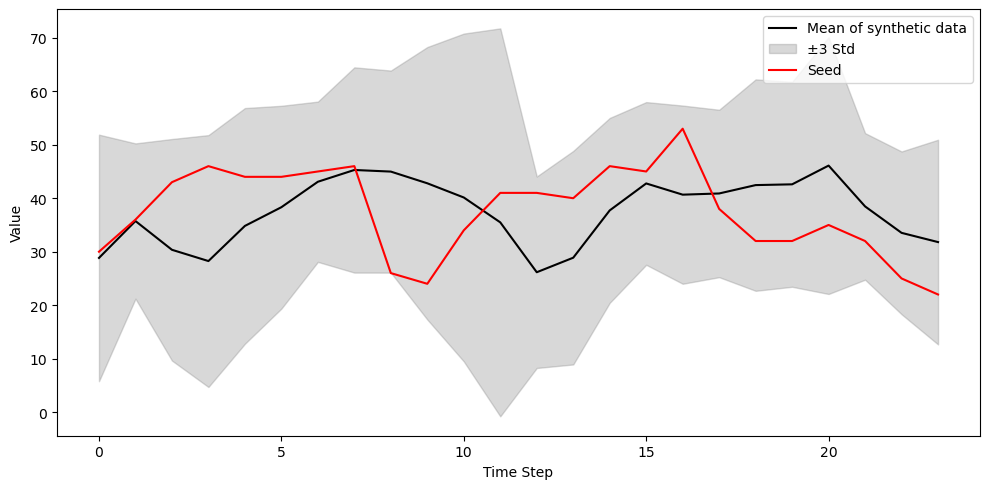

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

mean_series = np.nanmean(sample, axis=0)
std_series = np.nanstd(sample, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(mean_series, label="Mean of synthetic data", color="black")
plt.fill_between(
    np.arange(sample.shape[1]),
    mean_series - 3*std_series,
    mean_series + 3*std_series,
    alpha=0.3,
    color="gray",
    label="±3 Std"
)
plt.plot(cfg.SEED, label="Seed", color="red")

plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
sample,sample.shape

(array([[25.1932124 , 30.68277848, 28.60834087, ..., 35.96377039,
         32.6307577 , 30.35539365],
        [37.85204885, 29.63760416, 30.55613518, ..., 47.20675214,
         37.15583545, 20.04174619],
        [35.71548967, 38.85098253, 35.80657345, ..., 33.33531171,
         34.88848962, 37.09285237],
        ...,
        [28.99341568, 36.65363916, 20.73075507, ..., 42.56970026,
         29.71197804, 31.46553856],
        [35.75466815, 31.81558502, 32.84474082, ..., 41.50574916,
         34.57278723, 26.61128808],
        [31.84510185, 34.43888696, 33.71724451, ..., 43.69743037,
         26.3303193 , 24.31609689]]),
 (1000, 24))

In [ ]:
cfg.SEED




array([30, 36, 43, 46, 44, 44, 45, 46, 26, 24, 34, 41, 41, 40, 46, 45, 53,
       38, 32, 32, 35, 32, 25, 22])

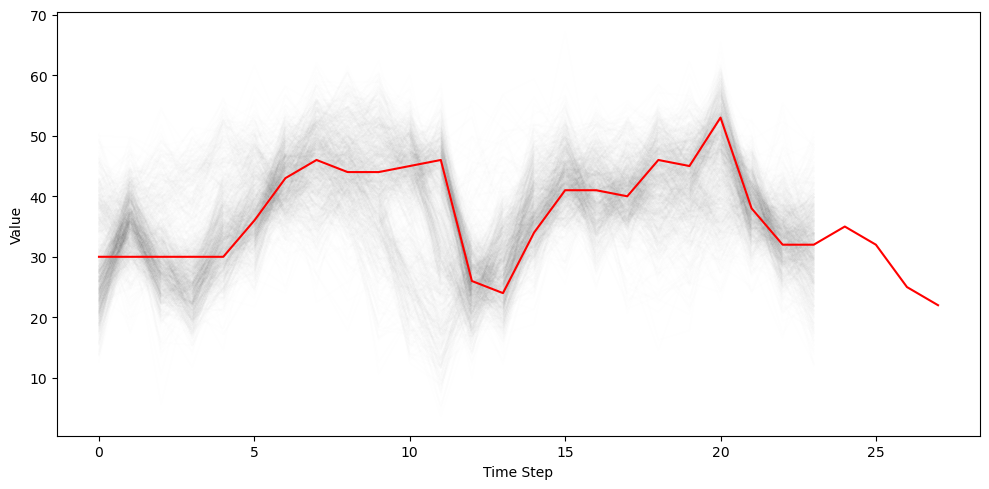

In [ ]:

import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))
for i in range(1000):
    plt.plot(sample[i], label="Mean of synthetic data", color="black", alpha=0.005)

plt.plot(np.insert(cfg.SEED, 0, [30,30,30,30]), label="Seed", color="red")

plt.xlabel("Time Step")
plt.ylabel("Value")
# plt.legend()
plt.tight_layout()
plt.show()



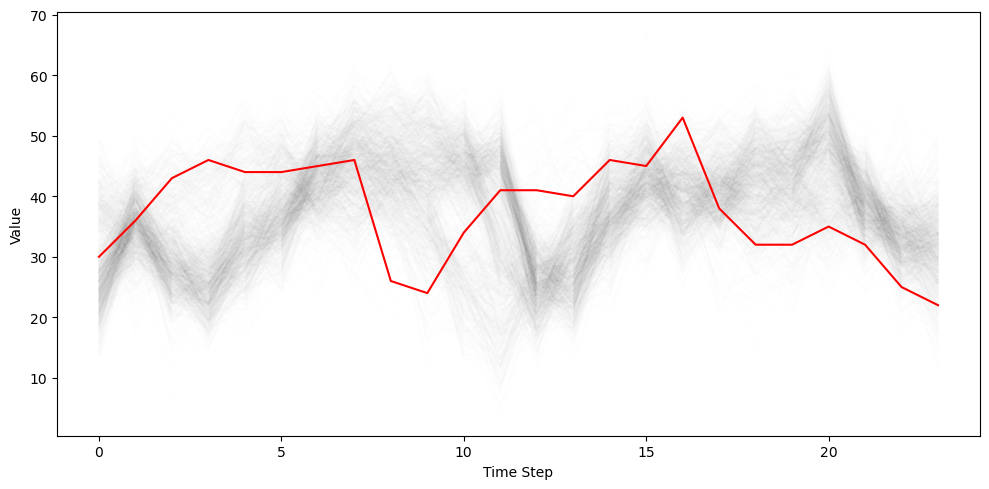

In [ ]:

import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))
for i in range(1000):
    plt.plot(sample[i], label="Mean of synthetic data", color="black", alpha=0.005)

plt.plot(cfg.SEED, label="Seed", color="red")

plt.xlabel("Time Step")
plt.ylabel("Value")
# plt.legend()
plt.tight_layout()
plt.show()

